In [1]:
# !kaggle competitions download -c classify-leaves
# !mv classify-leaves.zip ../data/
# !unzip -n -q ../data/classify-leaves.zip -d ../data/classify-leaves/
!head ../data/classify-leaves/train.csv

image,label
images/0.jpg,maclura_pomifera
images/1.jpg,maclura_pomifera
images/2.jpg,maclura_pomifera
images/3.jpg,maclura_pomifera
images/4.jpg,maclura_pomifera
images/5.jpg,maclura_pomifera
images/6.jpg,ulmus_rubra
images/7.jpg,broussonettia_papyrifera
images/8.jpg,maclura_pomifera


In [2]:
import pandas as pd
import torch
import torchvision
from pathlib import Path

base_dir = Path("../data/classify-leaves/")

train_df = pd.read_csv(base_dir/"train.csv")
test_df = pd.read_csv(base_dir/ "test.csv")
classes = train_df.label.unique()
len(train_df), len(test_df), len(classes)

(18353, 8800, 176)

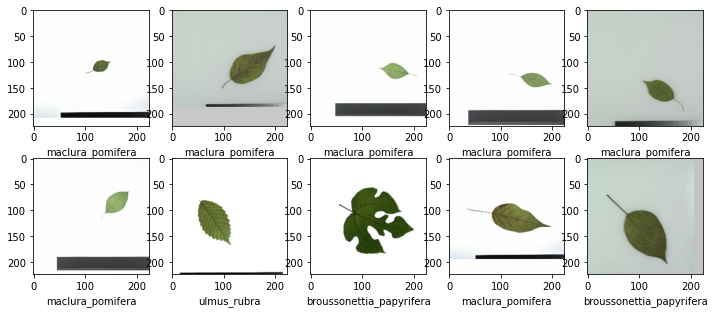

In [3]:
from  PIL import Image
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))
for i in range(10):
    img , label = train_df.iloc[i].image, train_df.iloc[i].label
    img = Image.open(base_dir/ img)
    ax = plt.subplot(2,5, i+1)
    ax.imshow(img)
    ax.set_xlabel(label)


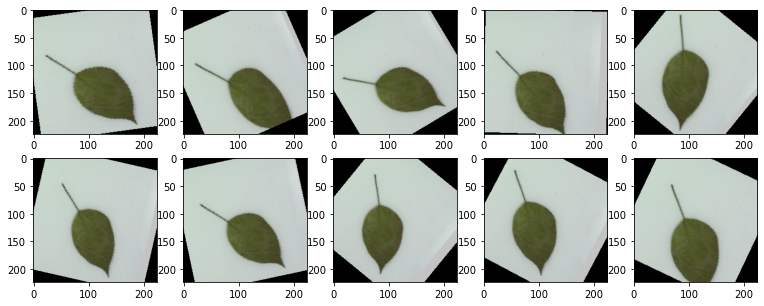

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch
from torchvision.transforms import Normalize, Compose, ToTensor, ColorJitter, RandomResizedCrop, RandomRotation, RandomVerticalFlip, RandomHorizontalFlip, Resize

labels = pd.read_csv(base_dir/"train.csv").label.unique().tolist()

to_tensor = ToTensor()
norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_transform = Compose([
    # RandomHorizontalFlip(), RandomVerticalFlip(), 
    # Resize(250),
    # RandomResizedCrop(224, scale = (0.64, 1)),
    # RandomRotation(45), 
    # ColorJitter(0.5,0.5,0.5),
    to_tensor, norm])
test_transform = Compose([to_tensor, norm])

img= train_df.iloc[i].image
img = Image.open(base_dir / img)
plt.figure(figsize= (13,5))
t = Compose([  Resize(250),
    RandomResizedCrop(224, scale = (0.64, 1)),
    RandomRotation(45), ])
for i in range(10):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(t(img))

In [5]:

class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X = Image.open(base_dir / self.data.iloc[index].image)
        if(self.transform):
            X = self.transform(X)
        y = labels.index(self.data.iloc[index].label)
        return X, y


def generate_dataloader(batch_size, test_ratio=0.2):
    all = pd.read_csv(base_dir/"train.csv")
    len_val = int(len(all) * 0.2)
    val_data = all.iloc[-len_val:]
    train_data = all.iloc[:-len_val]
    print(len_val, len(all), len(val_data), len(train_data))

    trainloader = DataLoader(ImageDataset(
        train_data, train_transform), batch_size, True, num_workers=4)
    testloader = DataLoader(ImageDataset(
        val_data, test_transform), batch_size, True, num_workers=4)
    return trainloader, testloader, labels


In [7]:
from torch import nn
from time import time
from tqdm import tqdm

batch_size = 32
trainloader, valloader, classes = generate_dataloader(batch_size)

model = torchvision.models.resnet18(True)
# for name, params in model.named_parameters():
#     if(not name.startswith("fc.")):
#         params.requires_grad_(False)

model.fc = nn.Linear(in_features=model.fc.in_features,
                     out_features=len(classes))

cnn_layer_params = [params for name, params in model.named_parameters() if not name.startswith("fc.")]

optimizer = torch.optim.Adam([
    {"params": model.fc.parameters(), "lr": 1e-3},
    {"params": cnn_layer_params,"lr":1e-4}
], lr=1e-4)
criterion = nn.CrossEntropyLoss()

def validate(model, dataloader, devices):
    model.eval()
    corrects, total = 0, 0
    for X, y in dataloader:
        X,y = X.to(devices[0]), y.to(devices[0])
        with torch.no_grad():
            # X, y = X.to(device), y.to(device)
            y_hat = model(X)
            corrects += (y_hat.argmax(-1) == y).sum().item()
            total += len(y)
    model.train()
    return corrects/total


scaler = torch.cuda.amp.GradScaler()
def train(epoch, model, optimizer, criterion, trainloader, testloader, devices=[torch.device("cuda")]):
    model = nn.DataParallel(model, devices)#Multi GPUs
    model.train()
    corrects, losses, total = 0, 0, 0
    start = time()
    with tqdm(total=len(trainloader)) as p:
        for X, y in trainloader:
            X,y = X.to(devices[0]), y.to(devices[0])
            optimizer.zero_grad()
            # with torch.cuda.amp.autocast(): # Mixed precision
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            optimizer.step()

            correct = (y_hat.argmax(-1) == y).sum().item()
            corrects+=correct
            total += len(y)
            losses += loss.item()

            p.update()
            p.set_description(
                f"epoch {epoch+1}, losss: {losses/p.n:.2f}, acc {100* correct/len(y):.2f}({100*corrects/total:.2f})%")

    times = time()-start
    v_acc = validate(model, testloader, devices)
    print(
        f"speed:{total/times:.2f} exmpales/s, time used:{times:.2f}secs, validate acc:{100*v_acc:.2f}%")


for epoch in range(20):
    train(epoch, model, optimizer, criterion, trainloader, valloader)


3670 18353 3670 14683


epoch 1, losss: 2.37, acc 59.26(43.65)%: 100%|██████████| 459/459 [02:33<00:00,  2.98it/s]


speed:95.43 exmpales/s, time used:153.85secs, validate acc:65.07%


epoch 2, losss: 0.85, acc 74.07(75.07)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s]


speed:95.60 exmpales/s, time used:153.59secs, validate acc:77.85%


epoch 3, losss: 0.53, acc 85.19(83.82)%: 100%|██████████| 459/459 [02:33<00:00,  2.98it/s]


speed:95.47 exmpales/s, time used:153.79secs, validate acc:81.47%


epoch 4, losss: 0.41, acc 100.00(87.09)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s]


speed:95.49 exmpales/s, time used:153.76secs, validate acc:81.88%


epoch 5, losss: 0.31, acc 92.59(90.15)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s] 


speed:95.55 exmpales/s, time used:153.67secs, validate acc:87.30%


epoch 6, losss: 0.27, acc 88.89(91.03)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s] 


speed:95.52 exmpales/s, time used:153.72secs, validate acc:85.07%


epoch 7, losss: 0.23, acc 96.30(92.17)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s] 


speed:95.53 exmpales/s, time used:153.70secs, validate acc:84.03%


epoch 8, losss: 0.23, acc 96.30(92.34)%: 100%|██████████| 459/459 [02:33<00:00,  2.99it/s] 


speed:95.51 exmpales/s, time used:153.74secs, validate acc:86.59%


epoch 9, losss: 0.20, acc 85.19(93.28)%: 100%|██████████| 459/459 [02:33<00:00,  2.98it/s] 
